In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")

In [3]:
import tools
from typing import List, Tuple

In [4]:
df = pd.read_csv("./data/CPIAUCSL.csv", index_col=0, parse_dates=True)
# df["DATE"] = pd.to_datetime(df["DATE"])
df.columns = ["CPI"]
print(df.dtypes)
df.head()
# month_df = df.resample("M").mean().head()

CPI    float64
dtype: object


,CPI
DATE,
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95
1947-06-01,22.08


In [5]:
slp = tools.gen_slp_sequential(df, num_time_steps=3)

Failed time step ignored: 859
Failed time step ignored: 860
Failed time step ignored: 861


In [6]:
X, y, ts = tools.format_instances(slp)

num_instances=859, num_inputs=1, num_outputs=1, num_time_steps=3


In [13]:
def split_dataset(
    X: np.ndarray,
    y: np.ndarray,
    ts: List[pd.Timestamp],
    ratio={"train": 0.8, "val": 0.1, "test": 0.1},
    shuffle=False
):
    if shuffle:
        raise NotImplementedError()
    train_end = int(ratio["train"] * X.shape[0])
    val_end = train_end + int(ratio["val"] * X.shape[0])
    
    X_train = X[:train_end, :, :]
    y_train = y[:train_end, :, :]
    ts_train = ts[:train_end]
    
    X_val = X[train_end: val_end, :, :]
    y_val = y[train_end: val_end, :, :]
    ts_val = ts[train_end: val_end]
    
    X_test = X[val_end:, :, :]
    y_test = y[val_end:, :, :]
    ts_test = ts[val_end:]
    
    return (X_train, y_train, ts_train,
            X_val, y_val, ts_val,
            X_test, y_test, ts_test
           )

In [14]:
(X_train, y_train, ts_train,
X_val, y_val, ts_val,
X_test, y_test, ts_test) = split_dataset(X, y, ts)

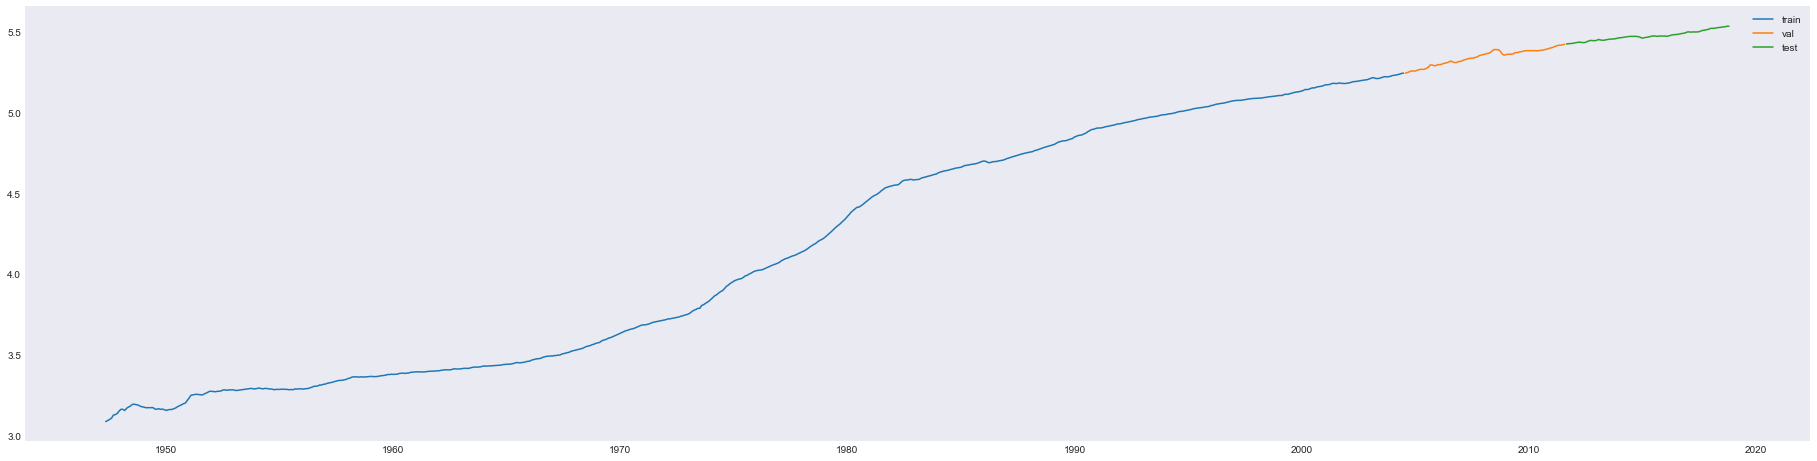

In [37]:
ax = plt.figure(figsize=(32,8))
plt.plot(ts_train, np.log(y_train[:, -1, :]), label="train")
plt.plot(ts_val, np.log((y_val[:, -1, :])), label="val")
plt.plot(ts_test, np.log(y_test[:, -1, :]), label="test")
plt.legend()
plt.show()

,CPI
DATE,
1947-02-01,3.073619
1947-03-01,3.091042
1947-04-01,3.091042
1947-05-01,3.088767
1947-06-01,3.094672
1947-07-01,3.101443
1947-08-01,3.109061
1947-09-01,3.128513
1947-10-01,3.131573
